In [1]:
import pandas as pd

data = pd.read_csv("final_merged_1min.csv", index_col=0)
data.isna().sum()
print("Size before dropna", len(data))
data.dropna(how="any", inplace=True)
print("Size after dropna", len(data))

Size before dropna 56250
Size after dropna 56125


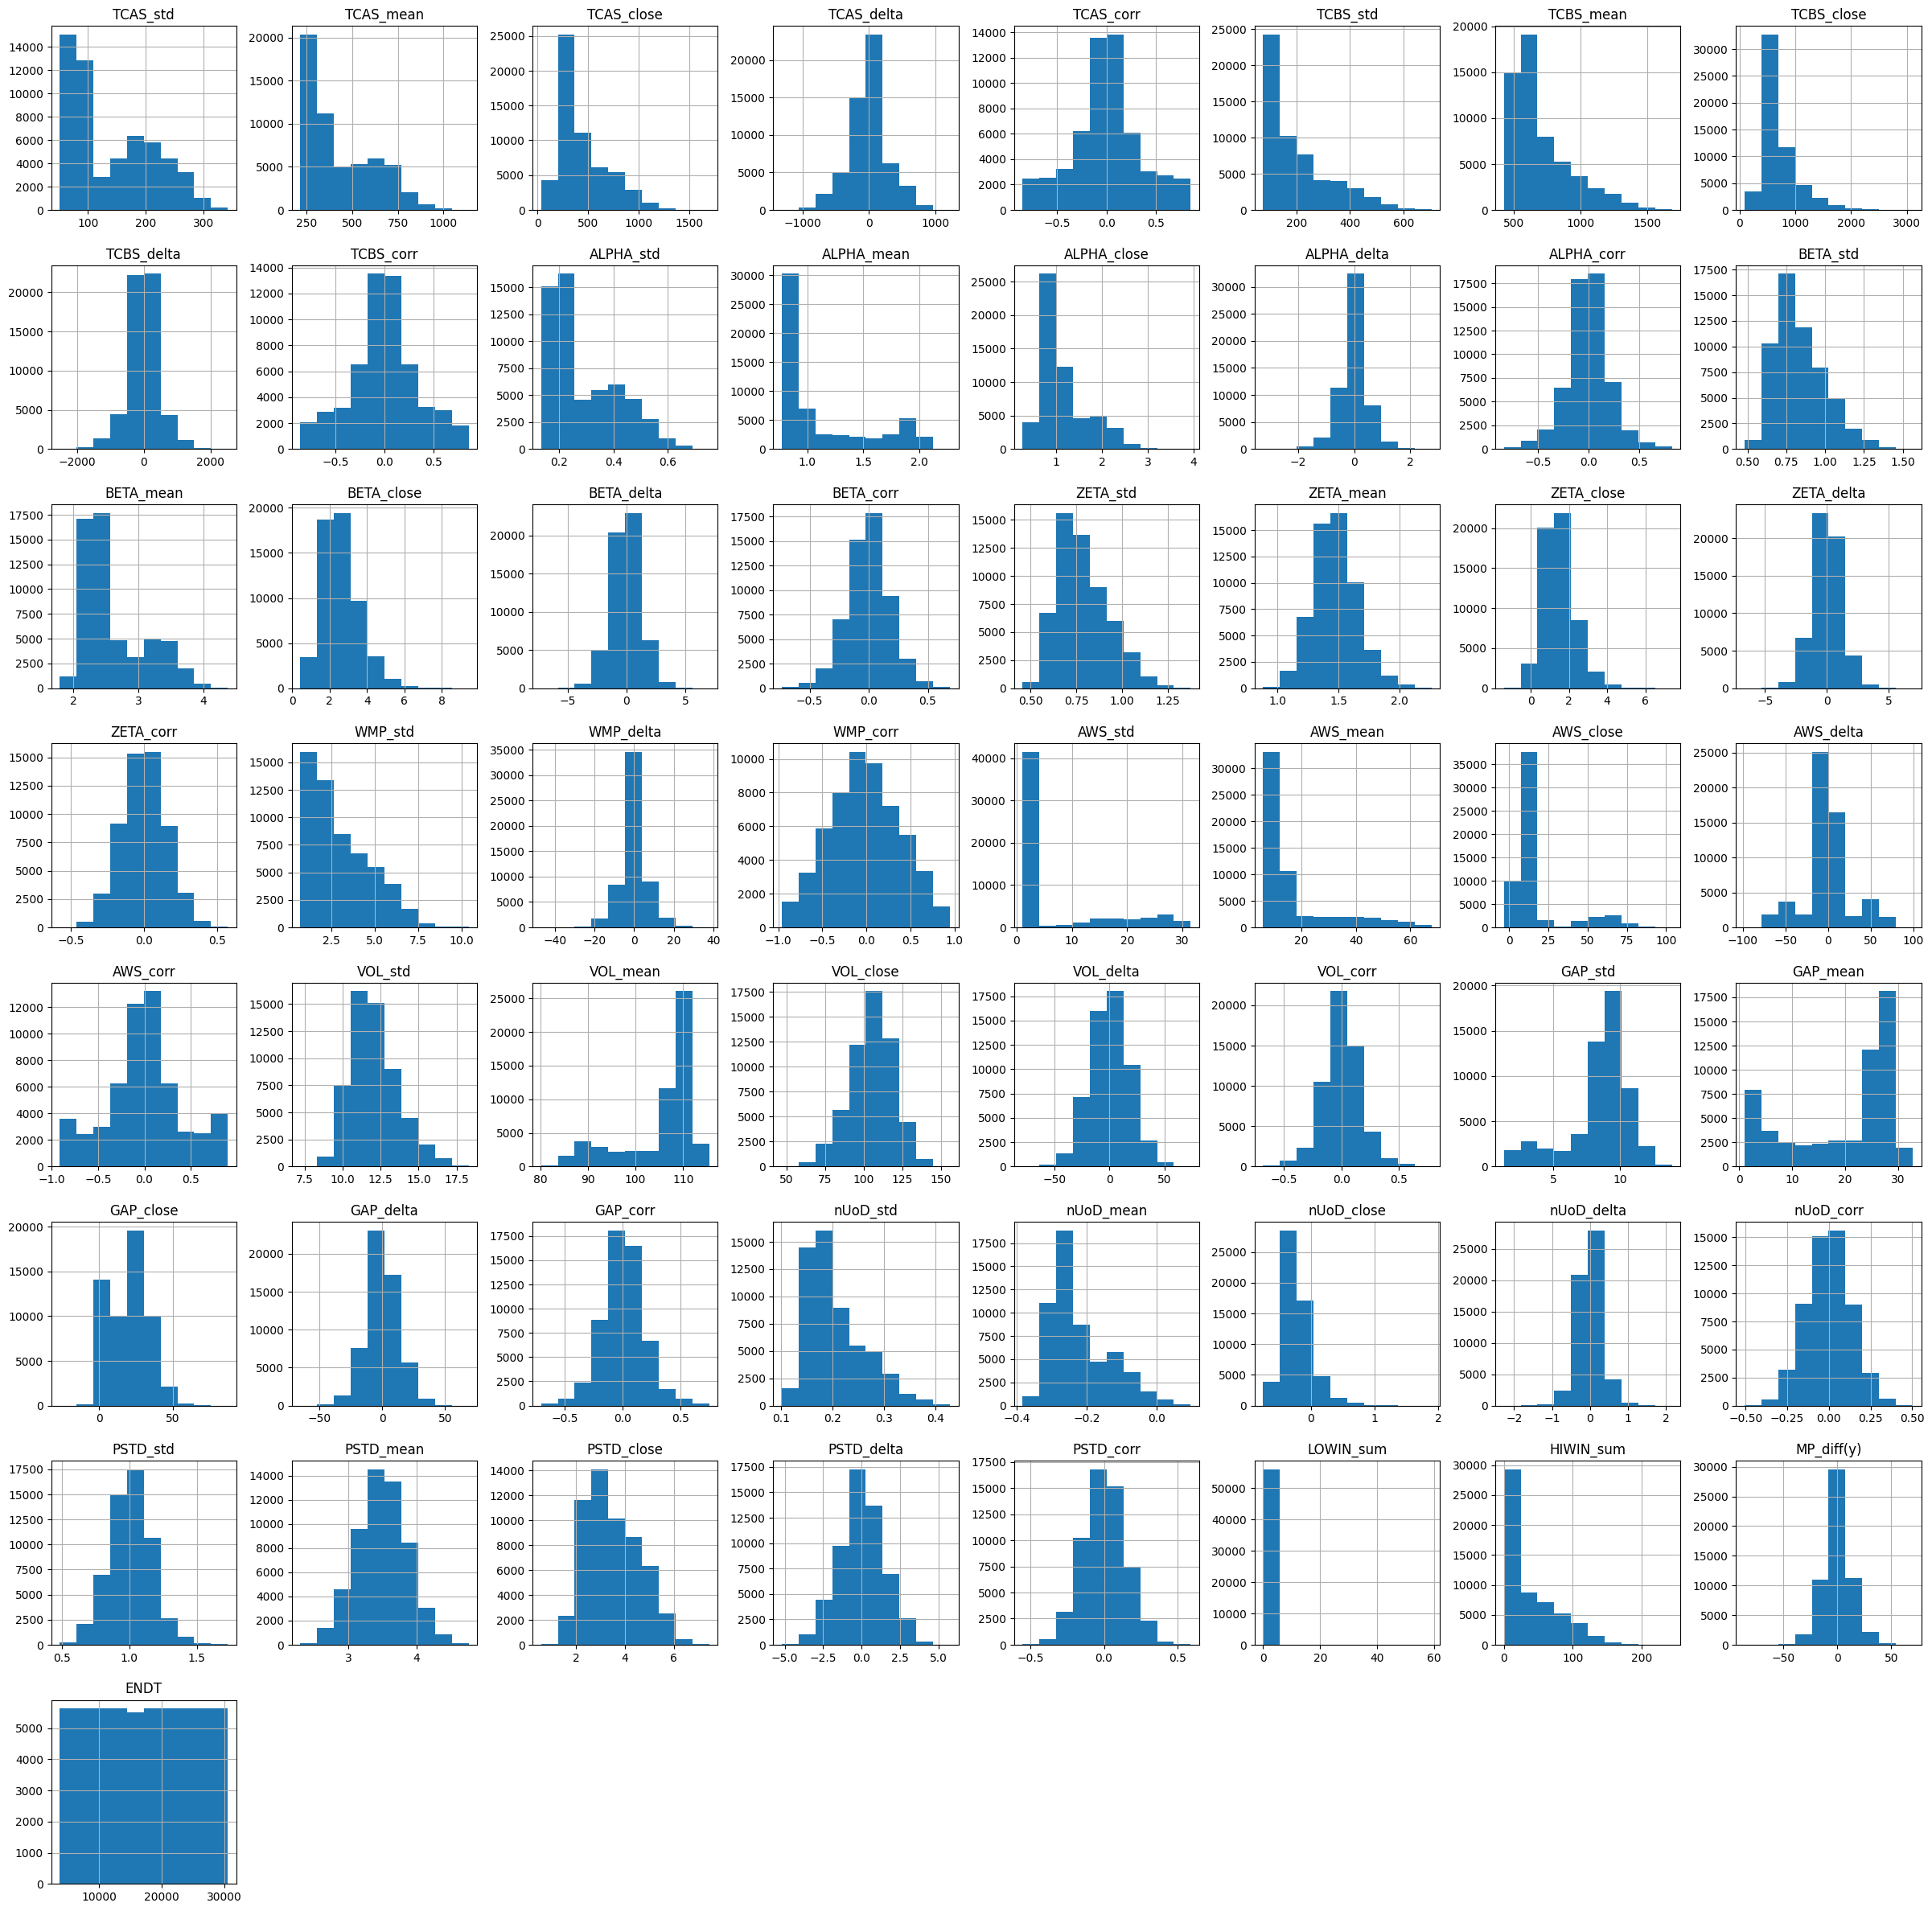

In [2]:
import matplotlib.pyplot as plt
data.hist(figsize=(30,30))
plt.show()

In [3]:
x_features = list(data)
x_features.remove("MP_diff(y)")
x_features.remove("ENDT")
x_features.remove("GAP_std")
x_features.remove("GAP_mean")
x_features.remove("GAP_close")
x_features.remove("GAP_delta")
x_features.remove("GAP_corr")

import numpy as np

# scale delta and std by mean
for col in x_features:
    if "WMP" not in col:
        if "std" in col or "delta" in col or "close" in col:
            data[col] = data[col] / data[col.split("_")[0] + "_mean"]

# scale data between 0 and 1
for col in x_features:
    #data[col] = np.log(data[col] + data[col].min())
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
    if data[col].median() < 0.2:
        data[col] = np.log(data[col] + 1)

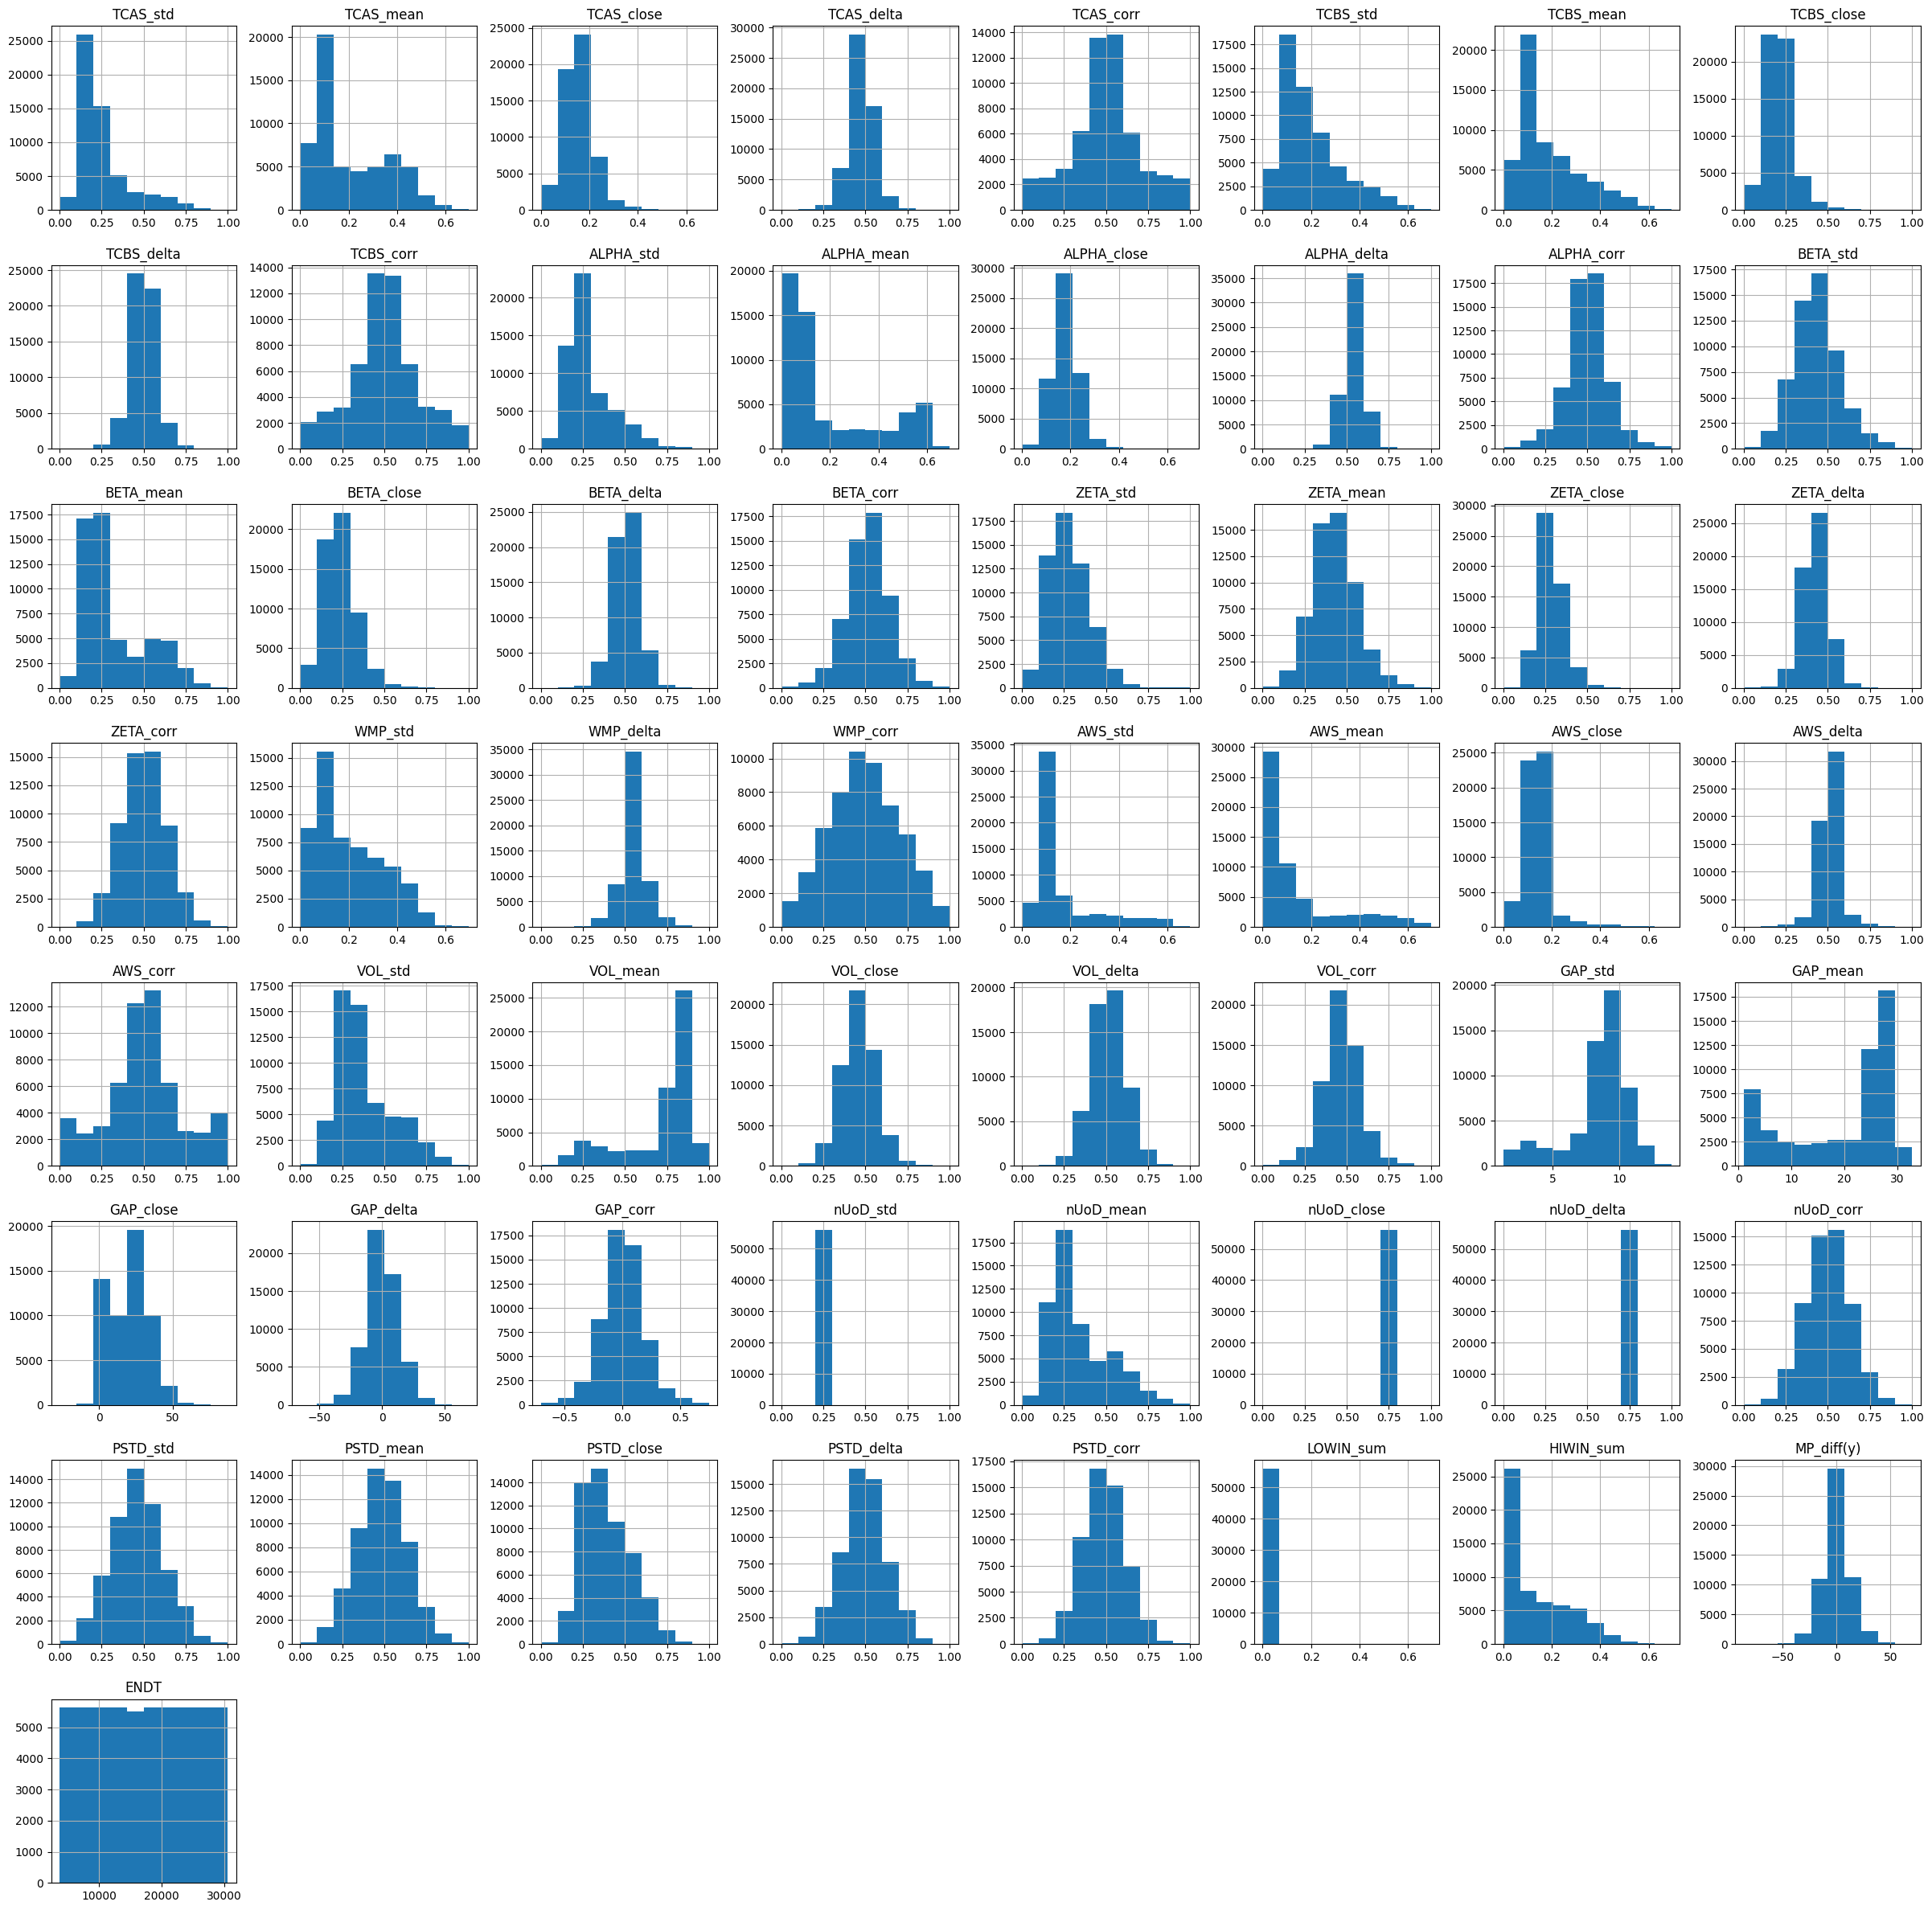

In [4]:
data.hist(figsize=(30,30))
plt.show()

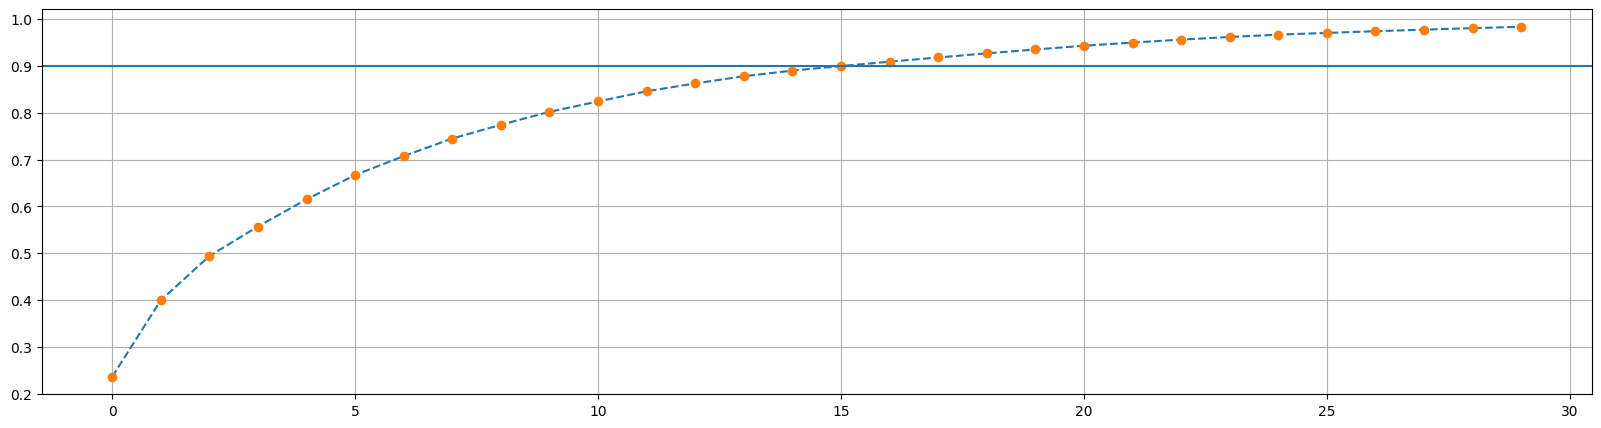

In [5]:
# apply pca
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=30)
pca_vectors = pca.fit_transform(data[x_features])

plt.figure(figsize=(20,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linestyle = "--")
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o')
plt.axhline(0.9)
plt.grid()

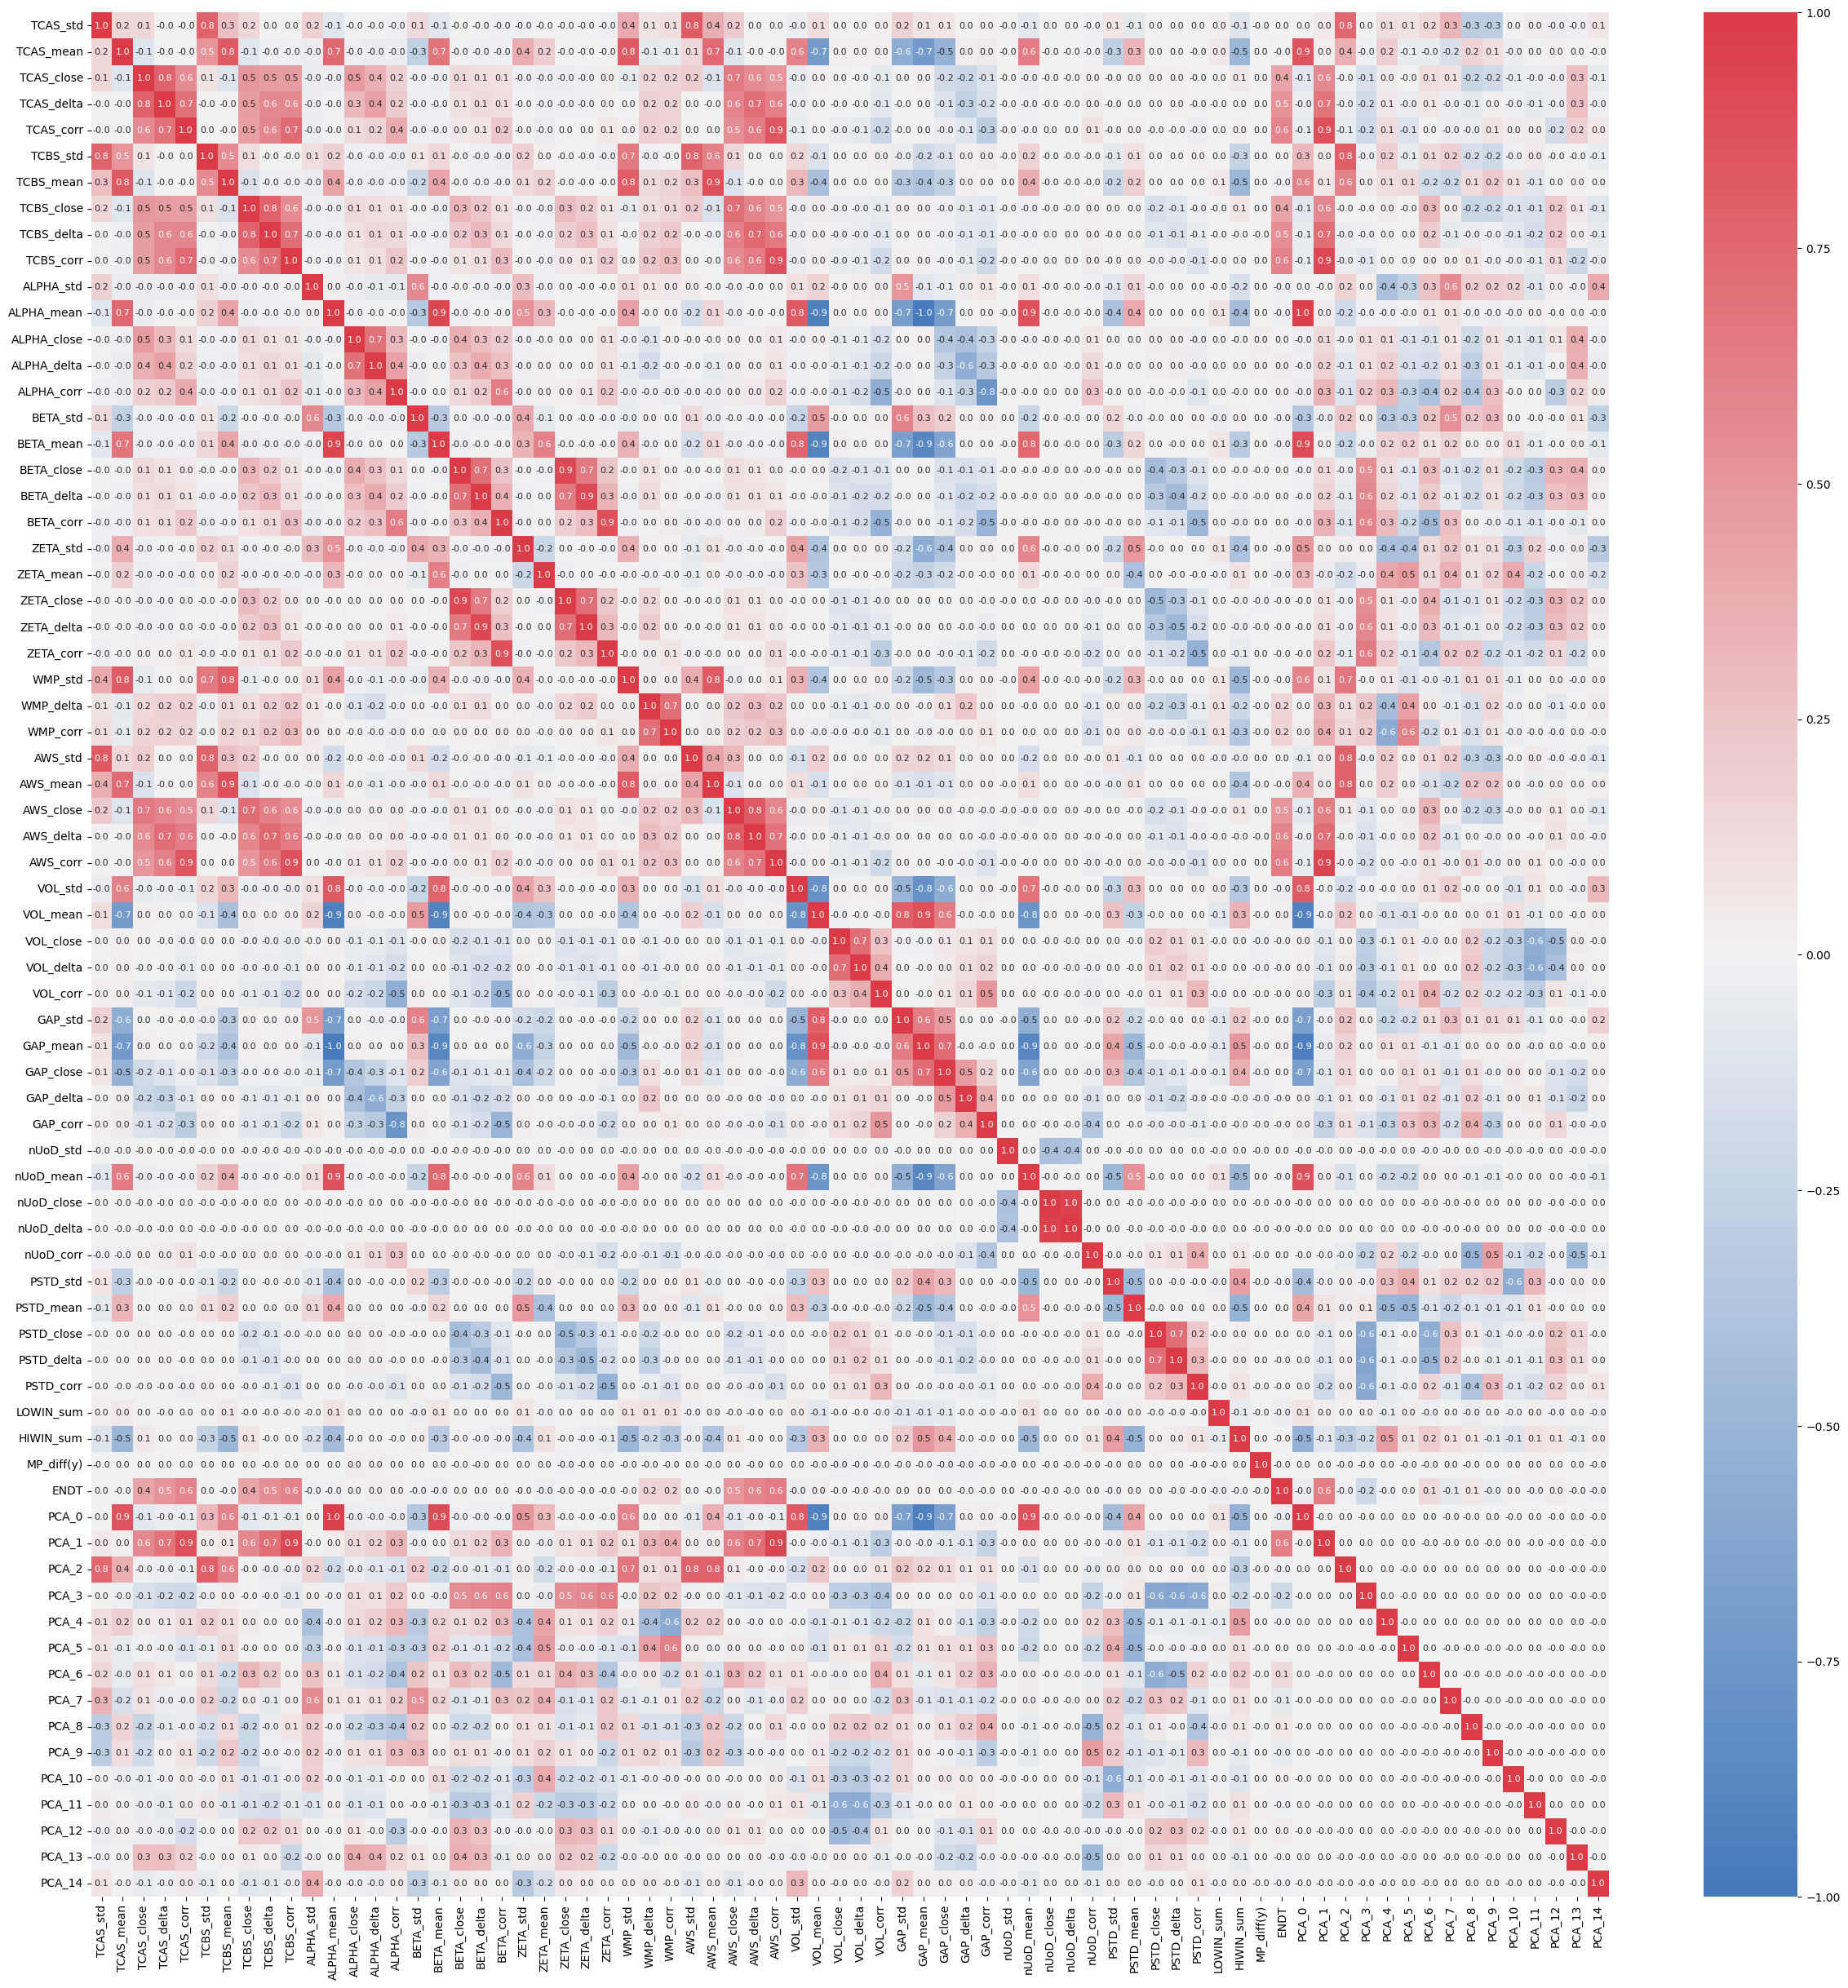

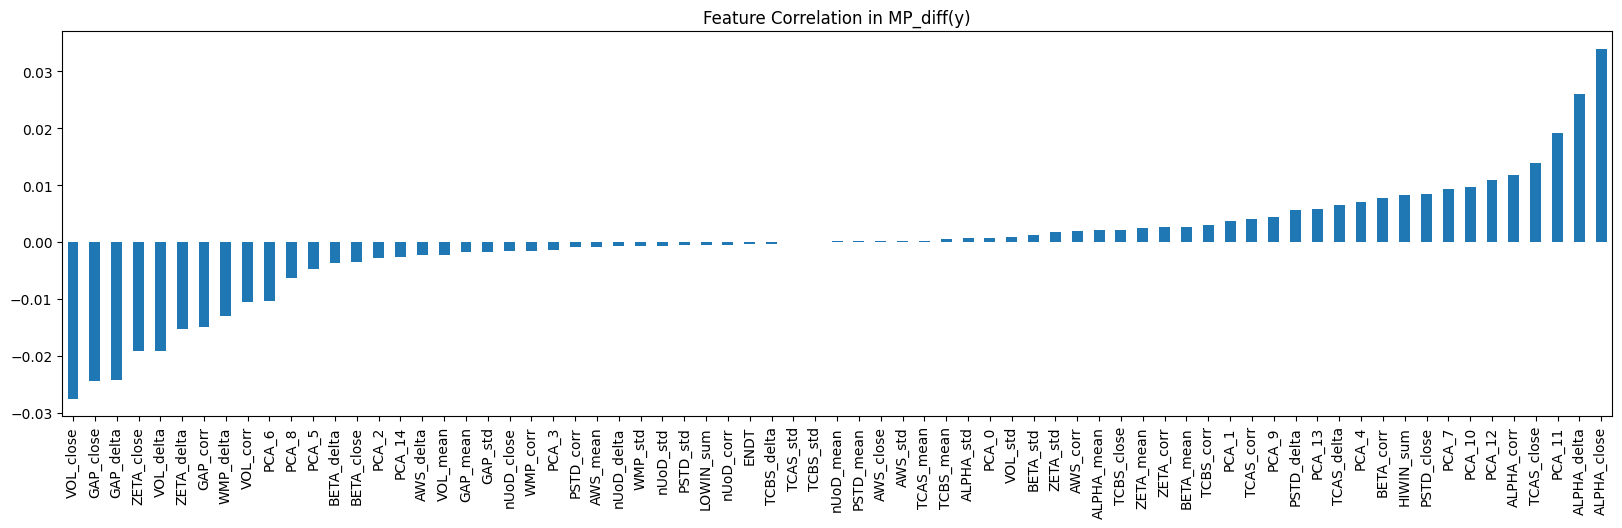

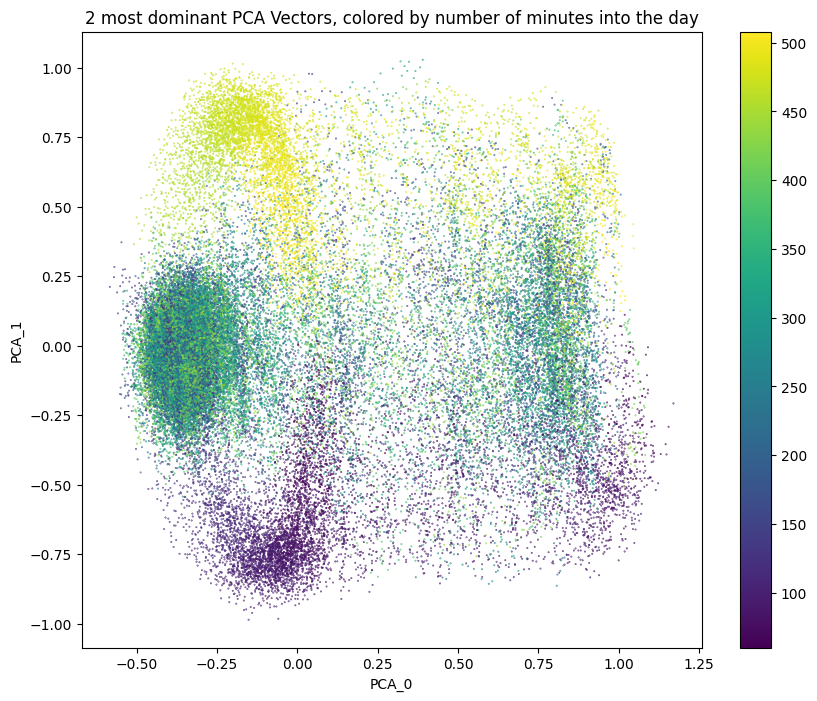

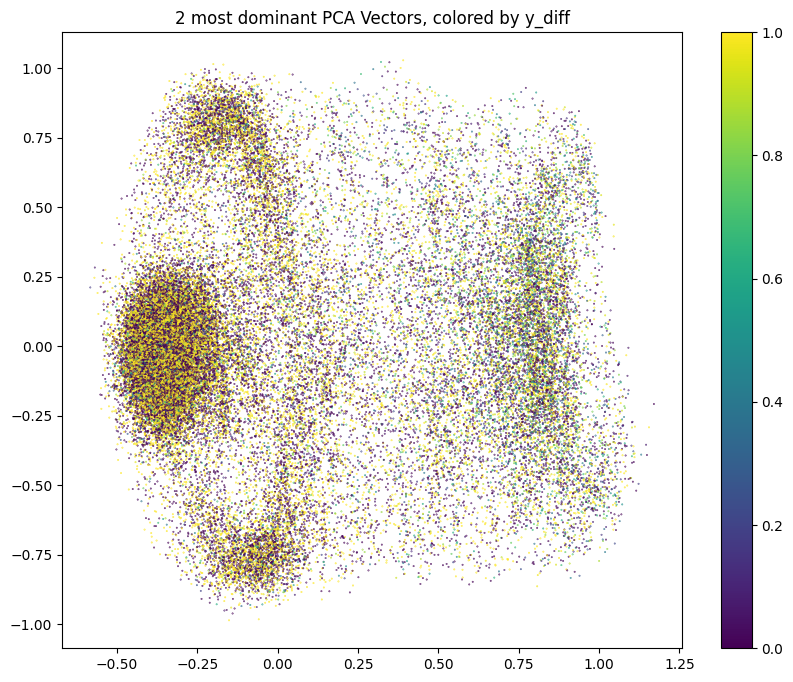

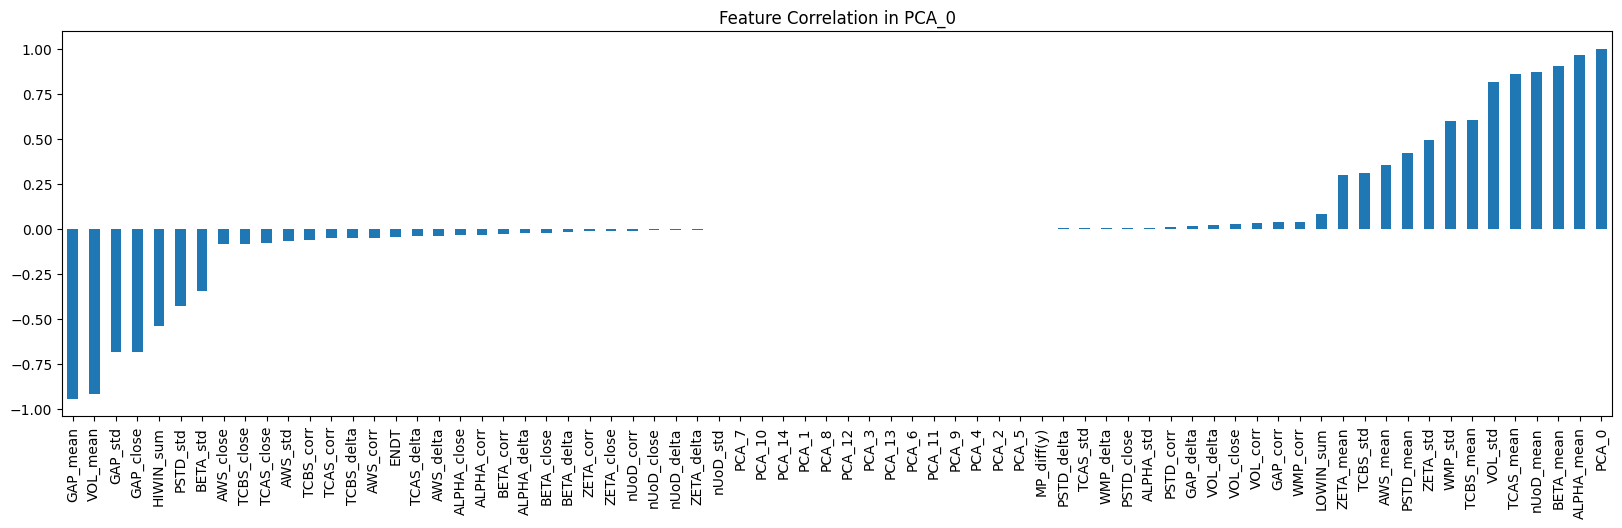

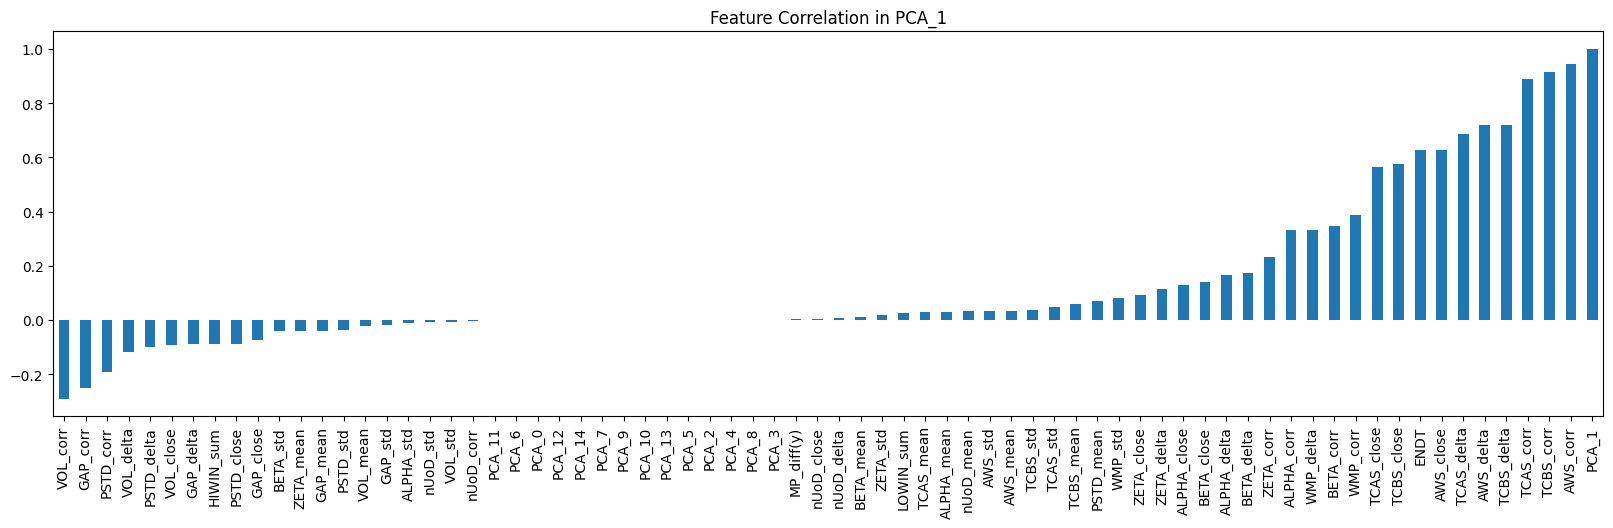

In [6]:
X = pca_vectors[:,:15]
y_diff = data["MP_diff(y)"]
import seaborn as sns


for i in range(X.shape[1]):
    data[f"PCA_{i}"] = X[:,i]

plt.figure(figsize=(30,30))
corr_map = data.corr()
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr_map, vmin=-1, vmax=1, cmap=cmap, center=0, annot=True, fmt=".1f", annot_kws={"size": 8})
plt.show()

corr_map[corr_map.index != "MP_diff(y)"]["MP_diff(y)"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in MP_diff(y)")
plt.show()

plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by number of minutes into the day")
plt.scatter(X[:,0], X[:,1], c = data.index.to_numpy(), s = 1/2**3)
plt.xlabel("PCA_0")
plt.ylabel("PCA_1")
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by y_diff")
plt.scatter(X[:,0], X[:,1], c = 1/ (1 + np.exp(-y_diff.to_numpy())), s = 1/2**3)
plt.colorbar()
plt.show()

corr_map["PCA_0"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in PCA_0")
plt.show()
corr_map["PCA_1"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in PCA_1")
plt.show()

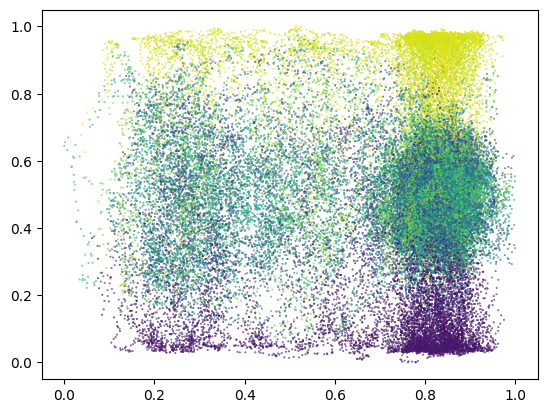

In [7]:
plt.scatter(data["VOL_mean"], data["AWS_corr"], s = 1/2**3, c = data["ENDT"])

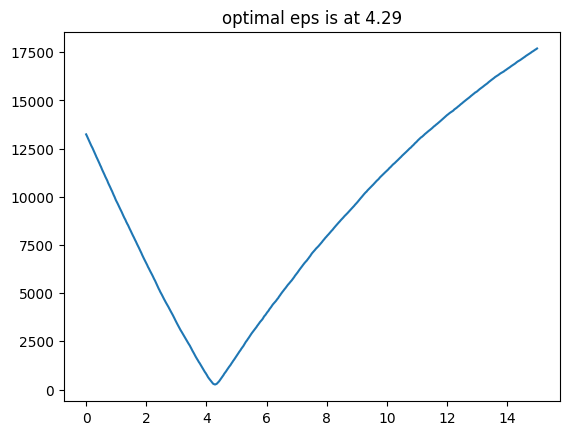

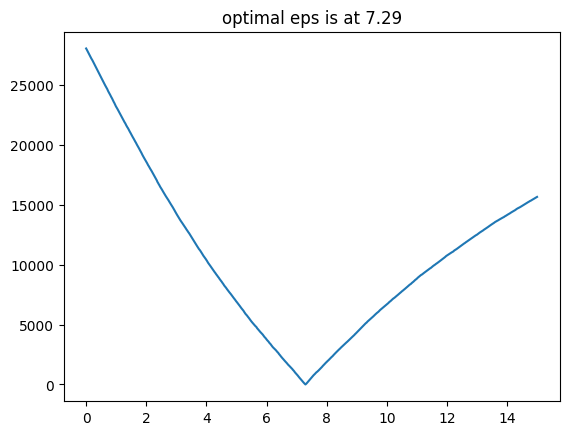

In [8]:
eps_vals = np.arange(0, 15, 0.01)

def eps_y_bool(arr, eps):
    return np.std([np.sum(arr > eps),np.sum(arr < -eps), np.sum( (arr < eps) & (arr > -eps) )])

def eps_y1_bool(arr, eps):
    return np.std([np.sum(arr > 1*eps) + np.sum(arr < -1*eps), np.sum( (arr < eps) & (arr > -eps) )])
    
split_ratios = []
split_ratios1 = []
for eps in eps_vals:
    split_ratios.append(eps_y_bool(y_diff, eps))
    split_ratios1.append(eps_y1_bool(y_diff, eps))

plt.title(f"optimal eps is at {eps_vals[np.argmin(split_ratios)]}")
plt.plot(eps_vals, split_ratios)
plt.show()

plt.title(f"optimal eps is at {eps_vals[np.argmin(split_ratios1)]}")
plt.plot(eps_vals, split_ratios1)
plt.show()

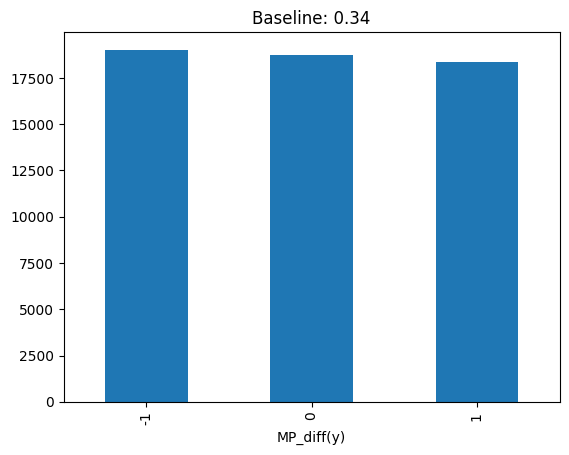

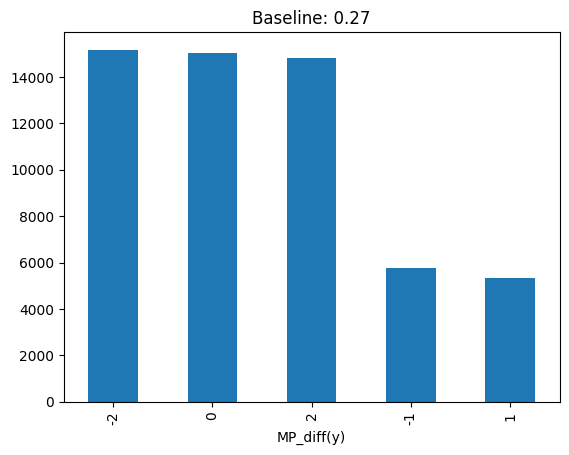

In [9]:
def gen_y_bool(y):
    if abs(y) < 4.29:
        return 0
    elif y > 0:
        return 1
    else:
        return -1
    
def gen_y1_bool(y):
    if abs(y) < 3.31:
        return 0
    elif y > 3.31:
        if y > 3.31 * 2:
            return 2
        else:
            return 1
    else:
        if y < -3.31:
            if y < -2 * 3.31:
                return -2
            else:
                return -1
    
y_bool = y_diff.apply(gen_y_bool)
y_bool_splits = y_bool.value_counts()
y_bool_splits.plot(kind = "bar")
baseline = np.max(y_bool_splits) / len(data)
plt.title(f"Baseline: {baseline:.2f}")
plt.show()

y1_bool = y_diff.apply(gen_y1_bool)
y1_bool_splits = y1_bool.value_counts()
y1_bool_splits.plot(kind = "bar")
baseline = np.max(y1_bool_splits) / len(data)
plt.title(f"Baseline: {baseline:.2f}")
plt.show()

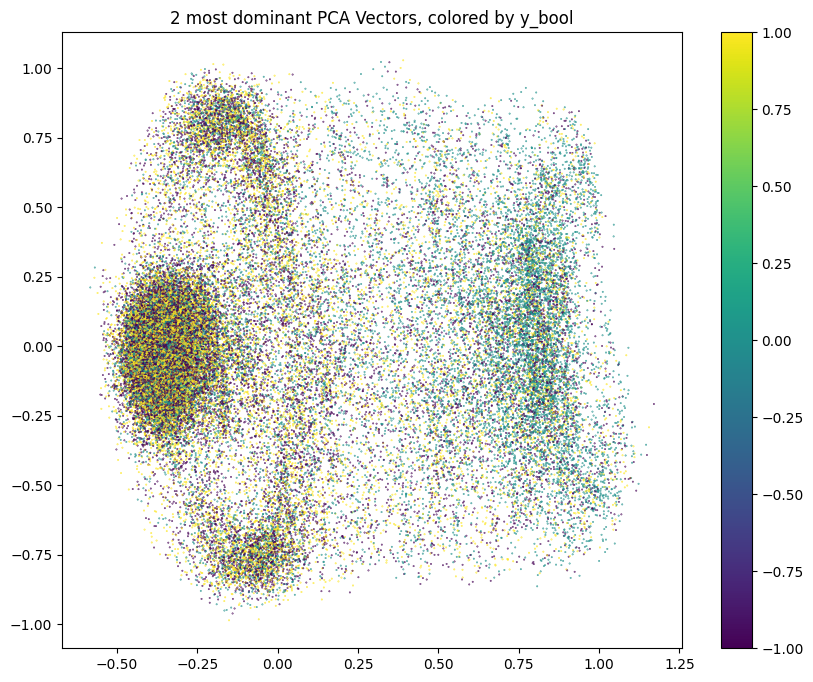

In [10]:
plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by y_bool")
plt.scatter(X[:,0], X[:,1], c = y_bool.to_numpy(), s = 1/2**3)
plt.colorbar()
plt.show()

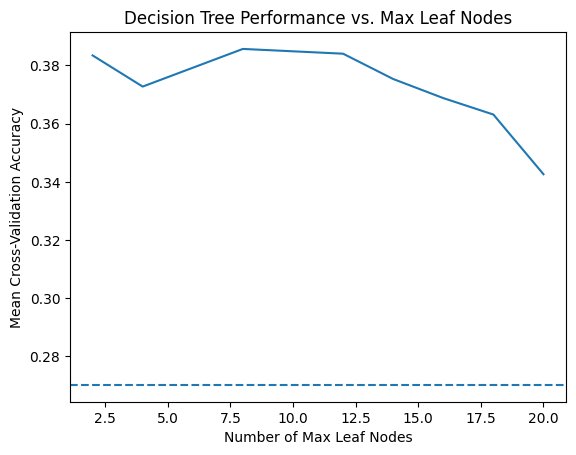

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


cv_scores = []
tree_nodes = [2,4,8,10,12,14,16,18,20]

for n in tree_nodes:
    clf = DecisionTreeClassifier(max_leaf_nodes=n)
    scores = cross_val_score(clf, data[x_features], y_bool, cv=5)  # Assuming you have data X and labels y
    cv_scores.append(scores.mean())

plt.plot(tree_nodes, cv_scores)
plt.xlabel('Number of Max Leaf Nodes')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Decision Tree Performance vs. Max Leaf Nodes')
plt.axhline(baseline, linestyle = "--")
plt.show()

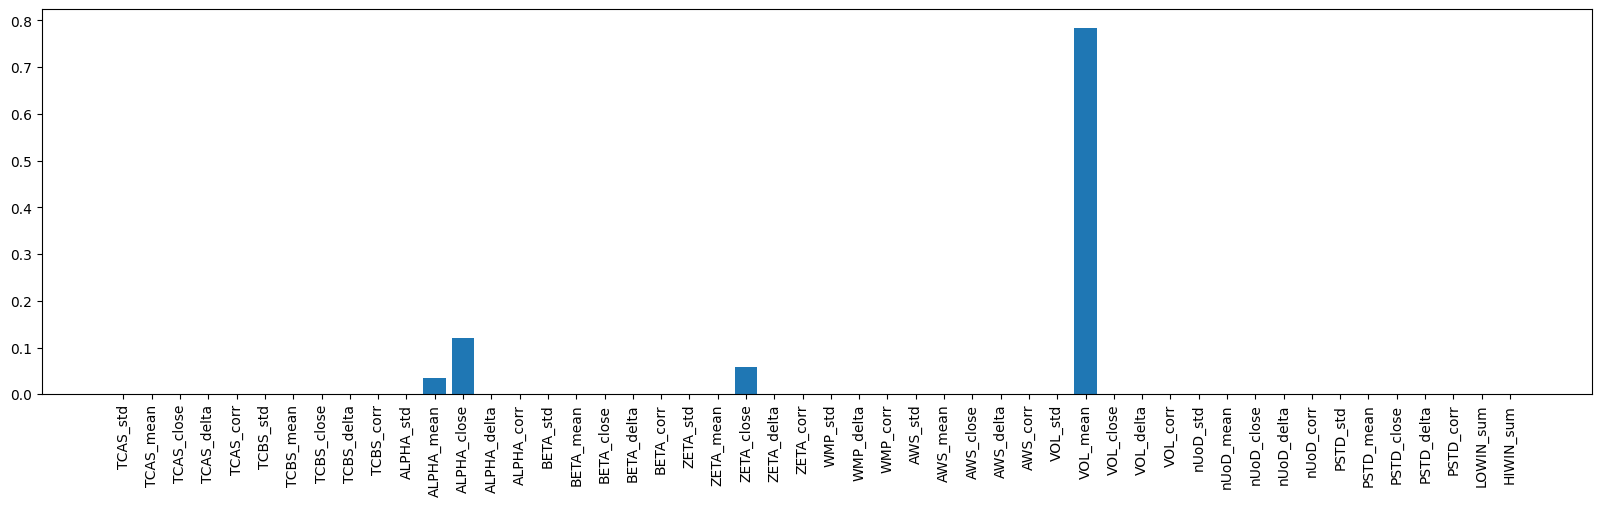

In [12]:
clf = DecisionTreeClassifier(max_leaf_nodes=8)
clf.fit(data[x_features],y_bool)

plt.figure(figsize=(20,5))
plt.bar(x_features, clf.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

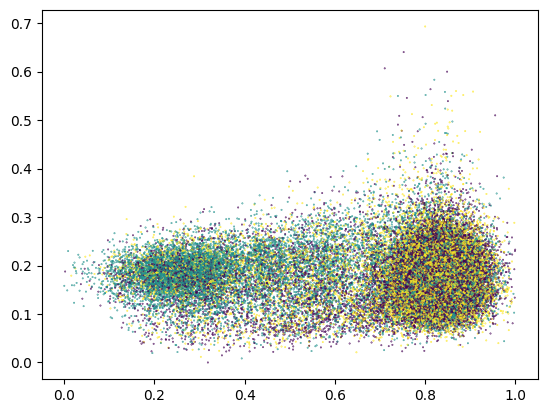

In [13]:
plt.scatter(data["VOL_mean"], data["ALPHA_close"], s = 1/2**3, c = y_bool)

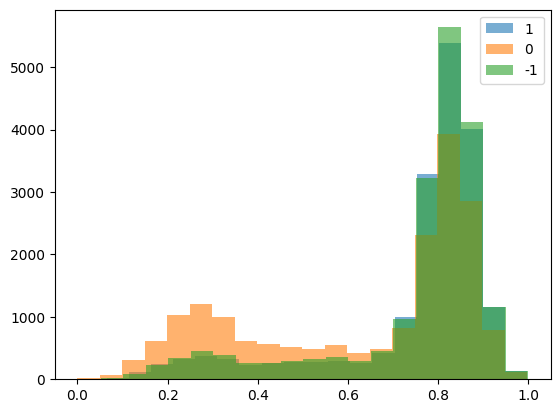

In [14]:
plt.hist(data[y_bool == 1]["VOL_mean"], bins = 20, alpha = 0.6, label = "1")
plt.hist(data[y_bool == 0]["VOL_mean"], bins = 20, alpha = 0.6, label = "0")
plt.hist(data[y_bool == -1]["VOL_mean"], bins = 20, alpha = 0.6, label = "-1")
plt.legend()
plt.show()

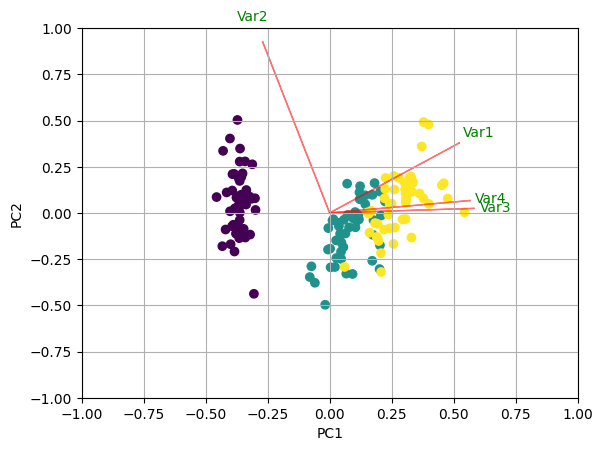

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X = data[x_features]
y = y_bool
#In general a good idea is to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    

pca = PCA()
x_new = pca.fit_transform(X)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()